# Model Training and Quantization


In this notebook, we will use the dataset created in the previous stage to train a model to detect persons based on CSI data. Then, we will optimize and export it for execution in real time using a ESP32 board.

This notebook is divided into four parts:
1) **Data importing and feature engineering** (from our previously created dataset)
2) **Model training using Tensorflow** (no expensive GPU required!)
3) **Model quantization using LiteRT** (for minimizing model size and inference time)
4) **Model convertion to C data array** (for execution on the ESP32)

## Imports


In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers

from tensorflow.keras import callbacks
import matplotlib.pyplot as plt

In [2]:
# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)
# Let's check our Tensorflow version
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.18.0


## Data importing and feature engineering

Let's import our train and test datasets. As a reminder, they are already separated from each other to prevent data contamination during the sliding window procedure.

In [3]:
df_train = pd.read_parquet("./DataProcessing/5_datasets/TRAIN_dataset_v2.parquet")
df_test = pd.read_parquet("./DataProcessing/5_datasets/TEST_dataset_v2.parquet")

In [4]:
# Let's have a look at how our data looks like!
df_test

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,100x43,100x44,100x45,100x46,100x47,100x48,100x49,100x50,100x51,100x52
0,1.0,-51.705446,-51.423908,-51.496811,-51.510120,-51.557132,-51.535879,-51.565779,-51.570532,-51.630636,...,-56.989539,-56.998313,-56.958502,-56.939802,-56.921101,-56.871816,-56.838084,-56.855117,-56.872150,-56.863376
1,1.0,-53.126589,-52.897802,-52.951718,-52.957503,-52.940708,-52.973299,-52.996578,-53.063365,-53.097971,...,-56.826967,-56.888419,-56.874295,-56.882567,-56.863333,-56.844099,-56.858878,-56.841845,-56.856624,-56.871403
2,1.0,-52.180428,-52.346506,-52.346735,-52.429096,-52.440990,-52.502765,-52.546891,-52.593040,-52.628934,...,-55.518491,-55.544820,-55.522918,-55.550747,-55.578576,-55.548514,-55.466558,-55.436496,-55.454657,-55.431944
3,1.0,-52.812095,-52.877571,-52.899397,-52.964835,-52.927434,-52.966386,-52.994210,-53.025664,-53.050129,...,-56.101104,-56.097376,-56.039618,-55.969037,-55.953594,-55.941600,-55.929607,-55.846010,-55.818094,-55.777377
4,1.0,-52.203216,-51.991086,-52.103481,-52.072961,-52.093341,-52.076188,-52.140729,-52.189136,-52.184420,...,-56.145657,-56.176241,-56.153277,-56.179606,-56.156643,-56.187227,-56.154775,-56.168080,-56.205064,-56.191338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,0.0,-72.377810,-72.377810,-72.517505,-72.521948,-72.524614,-72.481069,-72.546801,-72.558891,-72.568294,...,-73.800800,-73.821193,-73.892296,-73.912689,-73.983791,-74.004185,-74.037290,-74.070395,-74.103500,-74.083466
262,0.0,-72.672382,-72.672382,-72.672382,-72.647173,-72.731509,-72.704849,-72.736653,-72.739661,-72.760530,...,-74.016193,-74.038970,-74.062372,-74.104192,-74.102771,-74.054800,-74.006829,-73.958858,-73.910887,-73.886064
263,0.0,-73.016966,-72.811591,-72.959830,-72.982882,-73.077856,-73.073553,-73.094410,-73.061929,-73.079443,...,-72.806474,-72.828655,-72.916206,-72.990956,-73.006063,-72.963709,-72.978816,-73.055776,-73.015347,-73.023000
264,0.0,-73.954359,-73.851209,-74.123166,-74.110712,-74.103240,-74.098258,-74.094700,-74.092032,-74.117538,...,-75.004124,-75.035671,-75.003684,-74.963917,-74.955697,-74.947476,-74.939256,-74.899489,-74.859722,-74.819955


There are two labels: ```0``` represents ambient background noise, and ```1``` represents a person walking between the ESP32 boards.

For each dataset sample (row) there are 5200 features, denoting the CSI amplitudes of the 52 Wi-Fi subcarriers during a 100-frame window (a 1-second period).

In [5]:
# Separating our features from their labels
X_train = df_train.copy()
y_train = X_train.pop('label')
X_test = df_test.copy()
y_test = X_test.pop('label')

In [6]:
# Reshaping our labels for the required input dimensions
y_train = y_train.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)

### Feature engineering

Those 5200 features are a rather big input for our model, so now let's reduce them to a more manageable size using Principal Component Analisys (PCA)

First, we will scale the features using the StandardScaler

In [7]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

print(scaler.mean_)
print(scaler.scale_)

X_test = scaler.transform(X_test)

[-62.856 -62.837 -62.866 ... -64.028 -64.    -63.992]
[9.659 9.645 9.667 ... 8.251 8.247 8.25 ]


Now, we can train and apply our PCA! In this case, we will use a PCA that explains 99% of the data variance. Lower % values will reduce the number of features even more, but potentially result in lower accuracy as well.

In [8]:
pca = PCA(n_components=0.99)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

print(pca.components_)
print(pca.components_.shape)

input_shape = (X_train.shape[1:])

[[ 0.014  0.014  0.014 ...  0.014  0.014  0.014]
 [-0.002 -0.002 -0.002 ... -0.001 -0.001 -0.001]
 [-0.005 -0.005 -0.005 ... -0.002 -0.002 -0.002]
 ...
 [-0.009 -0.01  -0.01  ... -0.027 -0.027 -0.027]
 [-0.005 -0.005 -0.005 ... -0.002 -0.002 -0.002]
 [ 0.025  0.027  0.026 ...  0.019  0.019  0.019]]
(42, 5200)


Let's see what's our feature size now, after the PCA

In [9]:
input_shape

(42,)

From 5200 features per sample to only 42! That's a substantial size reduction.

Now, we can export our trained PCA and Scaler for later use in the ESP32.

In [10]:
# Exporting PCA and Scaler for the ESP32

n_features = scaler.mean_.size
n_frame = n_features // 52
n_components = pca.components_.shape[0]

# Reshape the parameters
scaler_mean = scaler.mean_.reshape(n_frame, 52)
scaler_std = scaler.scale_.reshape(n_frame, 52)
pca_mean = pca.mean_.reshape(n_frame, 52)
pca_components = pca.components_

with open('preprocessing.h', 'w') as f:
    f.write('#pragma once\n\n')

    f.write('#define SUBCARRIER_COUNT 52\n')
    f.write(f'#define FRAME_WINDOW_SIZE {n_frame}\n')
    f.write(f'#define PCA_COMPONENTS {n_components}\n\n')
    
    # Define the scaler struct
    f.write('typedef struct {\n')
    f.write('  float mean;\n')
    f.write('  float std;\n')
    f.write('} standard_scaler;\n\n')

    f.write(f'extern const standard_scaler scaler[FRAME_WINDOW_SIZE][SUBCARRIER_COUNT];\n')
    f.write(f'extern const float pca_means[FRAME_WINDOW_SIZE][SUBCARRIER_COUNT];\n')
    f.write(f'extern const float pca_matrix[PCA_COMPONENTS][SUBCARRIER_COUNT * FRAME_WINDOW_SIZE];\n')

with open('preprocessing.c', 'w') as f:
    f.write('#include "preprocessing.h"\n\n')

    # Dump scaler params
    f.write('const standard_scaler scaler[FRAME_WINDOW_SIZE][SUBCARRIER_COUNT] = {\n')
    for i in range(n_frame):
        f.write('    {')
        for j in range(52):
            mean_val = scaler_mean[i, j]
            std_val = scaler_std[i, j]
            entry = '' if j == 0 else ' '
            entry += f'{{ .mean = {mean_val:.6f}f, .std = {std_val:.6f}f }}'
            entry += ',' if j < 51 else ''
            f.write(entry)
        frame_end = '},\n' if i < n_frame - 1 else '}\n'
        f.write(frame_end)
    f.write('};\n\n')

    # Dump PCA means
    f.write('const float pca_means[FRAME_WINDOW_SIZE][SUBCARRIER_COUNT] = {\n')
    for i in range(n_frame):
        entries = '{'
        entries += ', '.join(f'{val:.6f}f' for val in pca_mean[i])
        row_end = '},\n' if i < n_frame - 1 else '}\n'
        f.write(f'    {entries}{row_end}')
    f.write('};\n\n')
    
    # Dump PCA matrix
    f.write('const float pca_matrix[PCA_COMPONENTS][SUBCARRIER_COUNT * FRAME_WINDOW_SIZE] = {\n')
    for idx, comp in enumerate(pca_components):
        entries = '{'
        entries += ', '.join(f'{val:.6f}f' for val in comp)
        row_end = '},\n' if idx < n_components - 1 else '}\n'
        f.write(f'    {entries}{row_end}')
    f.write('};\n')
    

The PCA and Scaler are now saved in the ```preprocessing.c``` file.

## Model training

Now that we have finished our feature engineering, we can finally train our model! Let's use a simple Multilayer Perceptron (MLP), to ensure the best compatibility possible with the ESP32. You could also try to use more complex models, but be sure to check for the [operation compatibility with the ESP-TFLITE-MICRO framework](https://github.com/espressif/esp-tflite-micro/blob/78e5532e682d3863a3c2985c3a74eed0a9ebaa61/tensorflow/lite/micro/micro_mutable_op_resolver.h#L45).


We will use an input layer with a number of neurons equal to the number of features, then add hidden layers dividing the number of neurons for 2 until we have our output.

We will also add Dropout layers in between each fully connected layer to reduce the chance of overfitting.

In [11]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(42, activation='relu',  input_shape=input_shape),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(32, activation='relu',  input_shape=input_shape),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(16, activation='relu',  input_shape=input_shape),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(8, activation='relu'),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(4, activation='relu'),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(2, activation='relu'),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

c:\Users\samuk\anaconda3\envs\sbrc\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 42)             │         1,806 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 42)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         1,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,895 (15.21 KB)

 Trainable params: 3,895 (15.21 KB)

 Non-trainable params: 0 (0.00 B)

Here, we train the model for 200 epochs, and save the model with the lowest train loss (which is correlated to the highest accuracy).

In [13]:
mc = callbacks.ModelCheckpoint('best_model.keras', monitor='loss', mode='min', verbose=1, save_best_only=True)
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=['binary_accuracy'])
history = model.fit(X_train, y_train, epochs=200, shuffle=True, batch_size=32, verbose=2, validation_data=(X_test, y_test), callbacks=mc)

Epoch 1/200

Epoch 1: loss improved from inf to 0.74668, saving model to best_model.keras
31/31 - 3s - 83ms/step - binary_accuracy: 0.4810 - loss: 0.7467 - val_binary_accuracy: 0.5188 - val_loss: 0.6921
Epoch 2/200

Epoch 2: loss improved from 0.74668 to 0.69788, saving model to best_model.keras
31/31 - 0s - 5ms/step - binary_accuracy: 0.5118 - loss: 0.6979 - val_binary_accuracy: 0.6128 - val_loss: 0.6914
Epoch 3/200

Epoch 3: loss improved from 0.69788 to 0.69650, saving model to best_model.keras
31/31 - 0s - 5ms/step - binary_accuracy: 0.5293 - loss: 0.6965 - val_binary_accuracy: 0.5940 - val_loss: 0.6889
Epoch 4/200

Epoch 4: loss improved from 0.69650 to 0.69034, saving model to best_model.keras
31/31 - 0s - 5ms/step - binary_accuracy: 0.5365 - loss: 0.6903 - val_binary_accuracy: 0.5564 - val_loss: 0.6872
Epoch 5/200

Epoch 5: loss improved from 0.69034 to 0.68833, saving model to best_model.keras
31/31 - 0s - 5ms/step - binary_accuracy: 0.5334 - loss: 0.6883 - val_binary_accuracy:

### Model evaluation

Let's make some plots to see how our training went

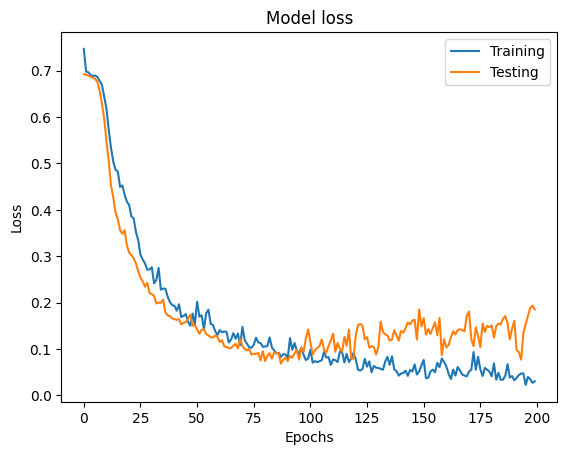

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training', 'Testing'])
plt.show()

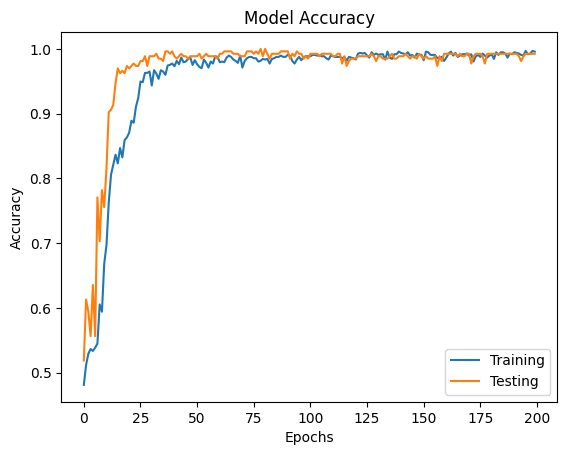

In [15]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training', 'Testing'])
plt.show()

So far, so good! It's a little unusual to see a training accuracy _lower_ than the testing accuracy, but this happens due to our use of Dropout. Our small dataset may also play a part in this, as the training set may have more difficult samples than the testing set.

Now, let's load our best model and evaluate its accuracy.

In [16]:
test_features = X_test
test_labels = y_test

In [17]:
saved_model = tf.keras.models.load_model("best_model.keras")
saved_model.evaluate(test_features, test_labels, verbose=2)

9/9 - 0s - 27ms/step - binary_accuracy: 0.9925 - loss: 0.1535


[0.15353737771511078, 0.9924812316894531]

Over 98% accuracy! Pretty good performance, given our small dataset and simple MLP model.

Let's plot our model's Confusion Matrix to analyse the performance for each class separately

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


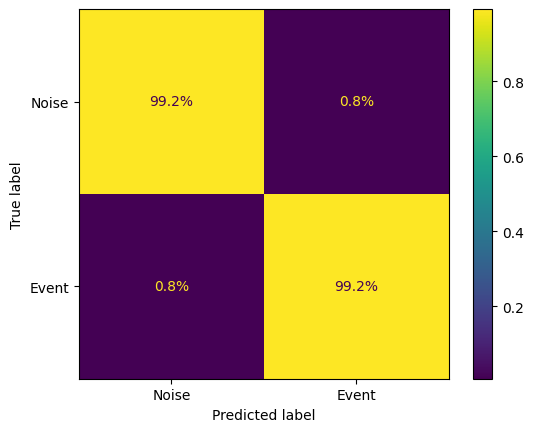

In [19]:
test_predictions = np.round(saved_model.predict(test_features))
ConfusionMatrixDisplay.from_predictions(test_labels, test_predictions, values_format= '.1%', normalize="true", display_labels=["Noise", "Event"])
plt.show()

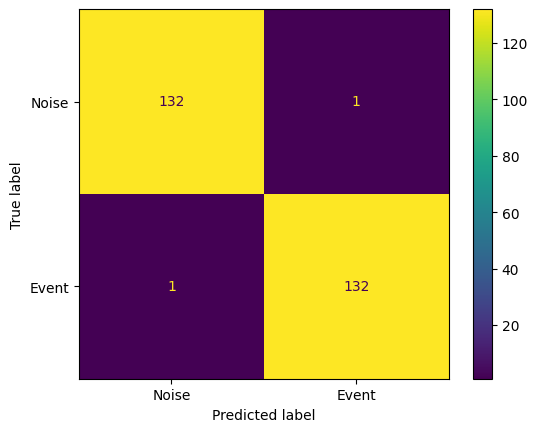

In [20]:
ConfusionMatrixDisplay.from_predictions(test_labels, test_predictions, display_labels=["Noise", "Event"])
plt.show()

Because this is a binary classification task, we have the false negative (miss rate) in the upper right corner, and the false positive (false alarm) rate in the lower left corner.

## Model quantization

After training our model, we need to quantize it for execution on the ESP32, transforming its weights and activations from floats to 8-bit integers. We will use the [LiteRT library](https://ai.google.dev/edge/litert/models/post_training_integer_quant) for this.

Before quantizing, let's define a function to evaluate our model after quantization.

In [21]:
def evaluate(interpreter):
    prediction = []
    #prediction_quantized = []
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]
    input_format = interpreter.get_output_details()[0]['dtype']
    input_details = interpreter.get_input_details()[0]

    for i, x in enumerate(X_test):
        if i % 100 == 0:
            print('Evaluated on {n} results so far.'.format(n=i))

        print("Non-quantized input:")
        print(x)

        # Quantize the input to uint8
        if input_details['dtype'] == np.uint8:
            input_scale, input_zero_point = input_details["quantization"]
            x = x / input_scale + input_zero_point

        x = np.expand_dims(x, axis=0).astype(input_format)
        print("Quantized input: ")
        print(x)

        interpreter.set_tensor(input_index, x)

        # Run inference.
        interpreter.invoke()

        # Gather and dequantize output
        output = interpreter.tensor(output_index)
        print("Quantized output:")
        print(output()[0])
        predicted_label = np.round(output()[0]/255)
        print("De-quantized output:")
        print(predicted_label)
        print("-----------------------------")
        prediction.append(predicted_label)

    print('\n')
    # Comparing prediction results with ground truth labels to calculate accuracy.
    prediction = np.array(prediction)
    #prediction_quantized = np.array(prediction_quantized)
    accuracy = (prediction == y_test).mean()
    return accuracy

INT8 post-training quantization requires a representative dataset. We will use 100 samples from our training set for this.

In [22]:
# Defining the representative dataset from the testing data
def representative_data_gen():
    for data in tf.data.Dataset.from_tensor_slices((X_test)).batch(1).take(100):
        #yield [tf.dtypes.cast(data, tf.float32)]
        yield [tf.dtypes.cast(data, tf.float32)]

Let's load our previously trained model and quantize it

In [23]:
# Our converter
model_to_convert = tf.keras.models.load_model("best_model.keras")
converter = tf.lite.TFLiteConverter.from_keras_model(model_to_convert)

# Set the representative dataset for post-training quantization.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen

# Using Integer Quantization.
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

# Setting the input and output tensors to uint8.
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

# Converting the model
int_quant_model = converter.convert()

# Saving the Integer Quantized TF Lite model.
with open('int8_quant_mlp.tflite', 'wb') as f:
    f.write(int_quant_model)

INFO:tensorflow:Assets written to: C:\Users\samuk\AppData\Local\Temp\tmpueebiu5a\assets


INFO:tensorflow:Assets written to: C:\Users\samuk\AppData\Local\Temp\tmpueebiu5a\assets


Saved artifact at 'C:\Users\samuk\AppData\Local\Temp\tmpueebiu5a'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 42), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2622187759632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2622187759824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2622187762128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2622185932176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2622185931600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2622185935056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2622185932368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2622185935632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2622185935440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2622185936208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2622185933712: 

c:\Users\samuk\anaconda3\envs\sbrc\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Now, let's evaluate our model performance after quantization. Our evaluator will print both inputs and outputs before and after quantization, just to illustrate how the process works.

In [24]:
# Passing the Int8 TF Lite model to the interpreter.
interpreter = tf.lite.Interpreter('int8_quant_mlp.tflite')

# Allocating tensors.
interpreter.allocate_tensors()

# Evaluating the model on the test dataset.
test_accuracy_quant = evaluate(interpreter)

# Printing the test accuracy for the FP-16 quantized TFLite model and the baseline Keras model.
print('Quantized TFLite Model Test Accuracy:', test_accuracy_quant*100)

Evaluated on 0 results so far.
Non-quantized input:
[ 62.364 -11.65  -24.387 -14.616   0.821  12.287   1.48   -7.877  -0.348
  -0.911   0.792   0.339   1.368   1.802   1.056  -0.108  -1.011  -0.823
   0.381  -2.822   1.313  -0.457  -1.102   0.009   0.799  -0.167   0.863
   0.13   -1.642   0.869   0.132   0.448   0.03   -0.493  -0.025  -0.261
   1.968  -0.259   1.504   0.063  -1.455   0.34 ]
Quantized input: 
[[213  61  34  54  86 110  88  68  84  83  86  85  87  88  87  84  82  83
   85  79  87  84  82  85  86  84  86  85  81  86  85  85  85  83  84  84
   89  84  88  85  82  85]]
Quantized output:
[249]
De-quantized output:
[1.]
-----------------------------
Non-quantized input:
[ 62.073 -24.319   0.104  -6.926 -18.911 -10.352   0.826   6.256  -2.053
  -0.903  -0.397   0.782  -1.34    0.076   1.253   1.492  -0.846  -0.434
   0.581  -1.993   1.832  -0.452   1.773   0.424  -0.385  -0.122   1.878
   1.034   0.055  -1.227  -0.853  -0.014  -1.197   0.207  -0.862   1.047
   1.833  -0.163  -

Over 90% accuracy! It's gone down from our non-quantized model, but it's still good enough for our application. Let's take a final look at our model before converting it for the ESP32:

In [25]:
tf.lite.experimental.Analyzer.analyze(model_path="int8_quant_mlp.tflite")

=== int8_quant_mlp.tflite ===

Your TFLite model has '1' subgraph(s). In the subgraph description below,
T# represents the Tensor numbers. For example, in Subgraph#0, the QUANTIZE op takes
tensor #0 as input and produces tensor #15 as output.

Subgraph#0 main(T#0) -> [T#24]
  Op#0 QUANTIZE(T#0) -> [T#15]
  Op#1 FULLY_CONNECTED(T#15, T#14, T#13[13, 16, -64, -171, -8, ...]) -> [T#16]
  Op#2 FULLY_CONNECTED(T#16, T#12, T#11[13, -418, -280, 502, 436, ...]) -> [T#17]
  Op#3 FULLY_CONNECTED(T#17, T#10, T#9[509, 127, -312, -224, 246, ...]) -> [T#18]
  Op#4 FULLY_CONNECTED(T#18, T#8, T#7[-117, -124, 230, 292, -140, ...]) -> [T#19]
  Op#5 FULLY_CONNECTED(T#19, T#6, T#5[-26, -1, 1, 3]) -> [T#20]
  Op#6 FULLY_CONNECTED(T#20, T#4, T#3[-1, 0]) -> [T#21]
  Op#7 FULLY_CONNECTED(T#21, T#2, T#1[1466]) -> [T#22]
  Op#8 LOGISTIC(T#22) -> [T#23]
  Op#9 QUANTIZE(T#23) -> [T#24]

Tensors of Subgraph#0
  T#0(serving_default_input_layer:0) shape_signature:[-1, 42], type:UINT8
  T#1(tfl.pseudo_qconst) shape:[1

## Converting the model to C data array


We need to convert our quantized .tflite model to a C data array format that can be easily loaded and interpreted in the ESP32. We use this helper function to convert it

In [26]:
import datetime

def convert_bytes_to_c_source(data,
                              array_name,
                              max_line_width=80,
                              include_guard=None,
                              include_path=None,
                              use_tensorflow_license=False):
  """Returns strings representing a C constant array containing `data`.

  Args:
    data: Byte array that will be converted into a C constant.
    array_name: String to use as the variable name for the constant array.
    max_line_width: The longest line length, for formatting purposes.
    include_guard: Name to use for the include guard macro definition.
    include_path: Optional path to include in the source file.
    use_tensorflow_license: Whether to include the standard TensorFlow Apache2
      license in the generated files.

  Returns:
    Text that can be compiled as a C source file to link in the data as a
    literal array of values.
    Text that can be used as a C header file to reference the literal array.
  """

  starting_pad = "   "
  array_lines = []
  array_line = starting_pad
  for value in bytearray(data):
    if (len(array_line) + 4) > max_line_width:
      array_lines.append(array_line + "\n")
      array_line = starting_pad
    array_line += " 0x%02x," % (value,)
  if len(array_line) > len(starting_pad):
    array_lines.append(array_line + "\n")
  array_values = "".join(array_lines)

  if include_guard is None:
    include_guard = "TENSORFLOW_LITE_UTIL_" + array_name.upper() + "_DATA_H_"

  if include_path is not None:
    include_line = "#include \"{include_path}\"\n".format(
        include_path=include_path)
  else:
    include_line = ""

  if use_tensorflow_license:
    license_text = """
/* Copyright {year} The TensorFlow Authors. All Rights Reserved.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
==============================================================================*/
""".format(year=datetime.date.today().year)
  else:
    license_text = ""

  source_template = """{license_text}
// This is a TensorFlow Lite model file that has been converted into a C data
// array using the tensorflow.lite.util.convert_bytes_to_c_source() function.
// This form is useful for compiling into a binary for devices that don't have a
// file system.

{include_line}
#include "model.h"

alignas(8) const unsigned char {array_name}[] = {{
{array_values}}};
const int {array_name}_len = {array_length};
"""

  source_text = source_template.format(
      array_name=array_name,
      array_length=len(data),
      array_values=array_values,
      license_text=license_text,
      include_line=include_line)

  header_template = """
{license_text}

// This is a TensorFlow Lite model file that has been converted into a C data
// array using the tensorflow.lite.util.convert_bytes_to_c_source() function.
// This form is useful for compiling into a binary for devices that don't have a
// file system.

#ifndef {include_guard}
#define {include_guard}

extern const unsigned char {array_name}[];
extern const int {array_name}_len;

#endif  // {include_guard}
"""

  header_text = header_template.format(
      array_name=array_name,
      include_guard=include_guard,
      license_text=license_text)

  return source_text, header_text

In [27]:
with open('int8_quant_mlp.tflite', 'rb') as f:
    bytes_data = f.read()
    source_text, source_header = convert_bytes_to_c_source(bytes_data, "g_model")

In [28]:
with open('model.cc', 'w') as f:
    f.write(source_text)

with open('model.h', 'w') as f:
    f.write(source_header)

We're all set! Now our model is saved at ```model.cc``` and ```model.h``` in a format suitable for use in the ESP32. If you made modifications to the models or the feature engineering process, remember to copy and pastecboth files, as well as the ```preprocessing.cc``` and ```preprocessing.h``` to the ```OnboardInference``` folder.